In [2]:
from astropy.table import Table
import astropy.units as u
import h5py

# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic_2d
from sklearn.model_selection import train_test_split

import os

import tensorflow as tf
from tensorflow.keras import regularizers

%matplotlib inline
params = {'text.usetex' : True,
          'font.size' : 10,
          'font.family' : 'lmodern',
          'figure.dpi': 140
          }
plt.rcParams.update(params) 

# Loading data in and preprocess
The dataset contains all stars with $m_G\in [5, 14.5), l\in[-20^\circ, 10^\circ), b\in [-10^\circ, 20^\circ)$

cuts:

1. `phot_g_mean_mag` < 14.5
2. `radial_velocity` is not null
3. `phot_rp_mean_mag` is not null
4. `fidelity_v2` > 0.5
5. `parallax` $> 0$
6. `parallax_error` $< 0.05\>\mathrm{mas}$
7. `ra_error` $< 0.05\>\mathrm{mas}$
8. `dec_error` $< 0.05\>\mathrm{mas}$
9. `radial_velocity_error` $< 10\>\mathrm{km/s}$
10. -20 deg < `l` < 10 deg
12. -10 deg < `b` < 20 deg

In [6]:
data = Table.read('data/gdr3_rvs_center.fits')

rng = np.random.default_rng(42)
data = data[rng.permutation(len(data))]

data[:5]

source_id,l,b,m_G,G-Rp,matched_transits,visibility_periods_used,astrometric_matched_transits,fidelity_v2,S
int64,float64,float64,float32,float32,int16,int16,int16,float32,int64
5961558819059374464,-7.810633349766704,-4.363794321426408,12.651129,0.576766,47,18,47,1.0,1
4053607215108141056,-5.762782150645762,-0.6922204782760002,11.558809,1.0916109,27,16,27,1.0,1
4035540899050214400,-8.68996209806528,-7.795491295642845,14.087217,1.0792332,42,18,42,1.0,1
4053032372336178944,6.079643611957238,-4.922835044615374,12.564264,1.1546726,25,15,24,0.9824219,1
4062893037506242304,3.062521503415553,-3.2245960820349207,13.626384,1.1481571,30,16,28,0.95751953,0


In [7]:
COLS_X = [
    'l',
    'b',
    'm_G',
    'G-Rp',
    'matched_transits',
    'visibility_periods_used',
    'astrometric_matched_transits',
    'fidelity_v2'
]
    
X = np.hstack([data[x].value.reshape(-1, 1) for x in COLS_X])
y = data['S'].value.astype('f8')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

def get_loss(prob_pred, y_test):
    return np.mean(-y_test*np.log(np.maximum(prob_pred, 0.001)) - (1 - y_test)*np.log(1 - np.minimum(prob_pred, 0.999)))

## Some data visualisation

/tmp/ipykernel_123264/3334717238.py:12: RuntimeWarning: invalid value encountered in divide
  ax.plot(bins[:-1], bin_vr/bin_all, label=r"has quality $v_r$", drawstyle='steps-post')


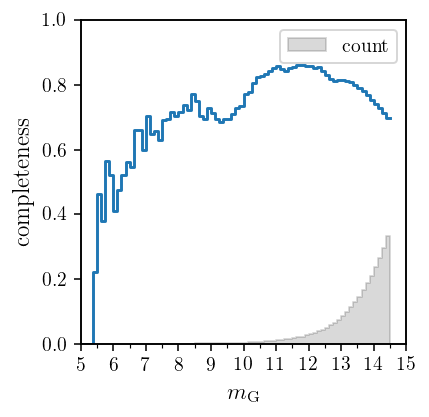

/tmp/ipykernel_123264/3334717238.py:38: RuntimeWarning: invalid value encountered in divide
  ax.plot(bins[:-1], bin_vr/bin_all, label=r"has quality $v_r$", drawstyle='steps-post')


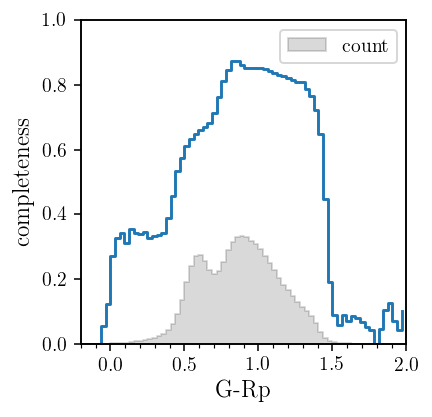

In [10]:
# The span of the data in degrees along l and b respectively
xlim = -20, 10
ylim = -10, 20

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

bins = np.linspace(0, 20, 161)
bins_center = 0.5*(bins[1:] + bins[:-1])
bin_all = np.histogram(data['m_G'].value, bins)[0]
bin_vr = np.histogram(data['m_G'].value[data['S'] == 1], bins)[0]

ax.plot(bins[:-1], bin_vr/bin_all, label=r"has quality $v_r$", drawstyle='steps-post')
ax.set_xlabel(r'$m_\mathrm G$', fontsize=12)
ax.set_ylabel(r'$\mathrm{completeness}$', fontsize=12)

ax2 = ax.twinx()
n = np.histogram(data['m_G'], bins)[0]
ax2.fill_between(bins[:-1], n, color='black', alpha=0.15, step='post', label='count')
ax2.set_ylim(0, 3*np.max(n))
ax2.set_yticks([])
ax2.legend()

ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.set_xlim(5, 15)
plt.show()



fig, ax = plt.subplots(1, 1, figsize=(3, 3))

bins = np.linspace(-0.5, 2, 81)
bins_center = 0.5*(bins[1:] + bins[:-1])
bin_all = np.histogram(data['G-Rp'].value, bins)[0]
bin_vr = np.histogram(data['G-Rp'].value[data['S'] == 1], bins)[0]

ax.plot(bins[:-1], bin_vr/bin_all, label=r"has quality $v_r$", drawstyle='steps-post')
ax.set_xlabel(r'G-Rp', fontsize=12)
ax.set_ylabel(r'$\mathrm{completeness}$', fontsize=12)

ax2 = ax.twinx()
n = np.histogram(data['G-Rp'], bins)[0]
ax2.fill_between(bins[:-1], n, color='black', alpha=0.15, step='post', label='count')
ax2.set_ylim(0, 3*np.max(n))
ax2.set_yticks([])
ax2.legend()

ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.set_xlim(-0.2, 2);

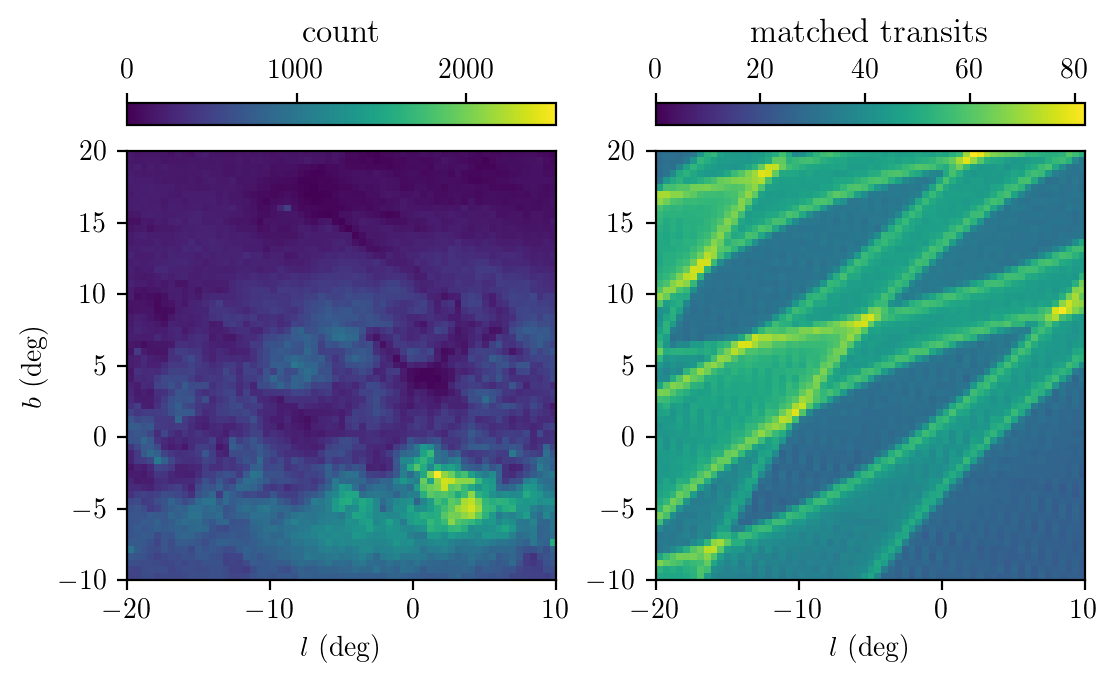

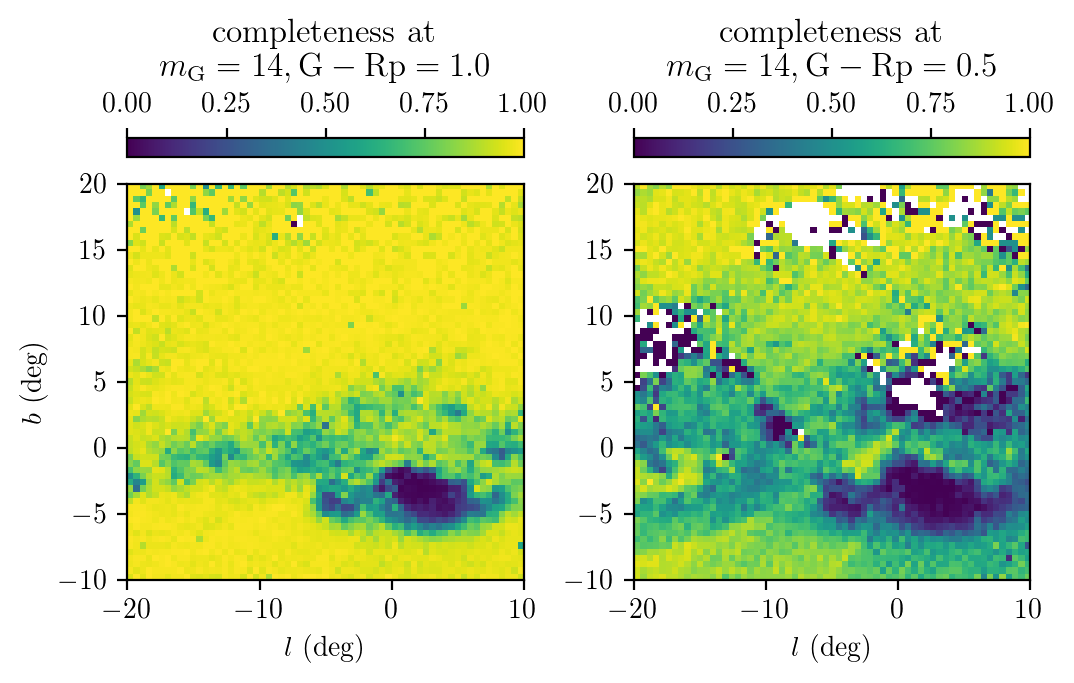

In [11]:
jobs = [
    (data['S'], 'count', 'count', None, dict(vmin=0)),
    (data['matched_transits'], 'mean', 'matched transits', None, dict(vmin=0)),
    (data['S'], 'mean', 'completeness at\n$m_\mathrm{G}=14, \mathrm{G-Rp}=1.0$',
        (data['m_G'] >= 13.6) & (data['m_G'] < 14.4) & (data['G-Rp'] >= 0.8) & (data['G-Rp'] < 1.2), dict()),
    (data['S'], 'mean', 'completeness at\n$m_\mathrm{G}=14, \mathrm{G-Rp}=0.5$',
        (data['m_G'] >= 13.6) & (data['m_G'] < 14.4) & (data['G-Rp'] >= 0.3) & (data['G-Rp'] < 0.7), dict()),
]

for i in range(len(jobs)//2):
    fig, axs = plt.subplots(2, 2,
            figsize=(6, 3*1.1),
            dpi=200,
            gridspec_kw=dict(height_ratios=[0.1, 2]),
            layout='compressed')
    caxs, axs = axs
    
    for ax in axs:
        ax.set_xlabel('$l\mathrm{\ (deg)}$')
        ax.set_aspect('equal')
        ax.invert_xaxis()
        
    for j, (z, statistic, title, idx, kw) in enumerate(jobs[2*i:2*(i+1)]):
        if idx is None:
            idx = np.ones(len(data), dtype=bool)
    
        axs[0].set_ylabel('$b\mathrm{\ (deg)}$')
    
        grid_size = 64
        xmin, xmax = xlim
        ymin, ymax = ylim
        x_bins = np.linspace(xmin, xmax, grid_size)
        y_bins = np.linspace(ymin, ymax, grid_size)
    
        ret = binned_statistic_2d(data[idx]['l'].value, data[idx]['b'].value, z[idx], statistic=statistic, bins=[x_bins, y_bins])
        im = axs[j].imshow(ret.statistic.T,
                origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='viridis',
                aspect='equal', rasterized=True, interpolation='none', **kw)
        cb = fig.colorbar(im, cax=caxs[j], orientation='horizontal')
        cb.ax.xaxis.set_ticks_position('top')
        caxs[j].set_title(title)        
        
    plt.show()

# Training a simple model

## Guessing the average completeness

In [12]:
# Loss with no rejections/upscaling
y_pred_naive = np.full_like(y_test, np.sum(y_train==1)/len(y_train), dtype='f4')

print(f'guessing 0.5:                      loss = {get_loss(0.5, y_test):.6f}')
print(f'guessing the average completeness: loss = {get_loss(y_pred_naive, y_test):.6f}')

guessing 0.5:                      loss = 0.693147
guessing the average completeness: loss = 0.541759


## Binning along $m_G$ and healpixel

In [13]:
from astropy_healpix import HEALPix

def get_counts(hp, l, b):
    l, b = u.Quantity(l, unit='deg'), u.Quantity(b, unit='deg')
    ihealpix = hp.lonlat_to_healpix(l, b)
    hp_counts = np.zeros(hp.npix)
    a, b = np.unique(ihealpix, return_counts=True)
    hp_counts[a] = b
    return hp_counts

mags = np.concatenate([np.arange(4, 12, 1), np.arange(12, 15., 0.5)])

class MagSkyClassifier:
    def __init__(self, pixel_density_goal=400):
        self.name = 'MagSkyClassifier'
        self.mags = mags
        self.mag_centers = 0.5*(self.mags[1:] + self.mags[:-1])
        
        self.pixel_density_goal = pixel_density_goal
        self.hps = []
        self._probs = []
        
    def fit(self, X, y):
        n_side_old = 0
        
        hp = HEALPix(nside=8, frame='galactic')
        for i in range(len(self.mags) - 1):
            m_min, m_max = self.mags[i], self.mags[i + 1]
            idx = (X[:, 2] < m_max) & (m_min <= X[:, 2])

            n_side = (np.sum(y[idx])*16/self.pixel_density_goal/12)**0.5
            pows = [1, 2, 4, 8, 16, 32, 64]
            n_side = min(pows, key=lambda x:abs(x-n_side))

            if n_side != n_side_old:
                hp = HEALPix(nside=n_side, frame='galactic')
            n_side_old = n_side
            print(f'm_G=[{m_min}, {m_max}): n_side={n_side}, n_stars/bin={np.sum(y[idx])/hp.npix:.0f}')

            mean_pix = np.sum(y[idx])/hp.npix

            hp_counts_vr = get_counts(hp, X[idx & (y==1)][:, 0], X[idx & (y==1)][:, 1])
            hp_counts_all = get_counts(hp, X[idx][:, 0], X[idx][:, 1])
            
            self._probs.append(hp_counts_vr/hp_counts_all)
            self.hps.append(hp)
            
    def prob(self, X):
        idxs = np.digitize(X[:, 2], self.mags) - 1
        ret = np.zeros(X.shape[0])
        
        for i in range(len(self.mag_centers)):
            l, b = u.Quantity(X[idxs==i][:, 0], unit='deg'), u.Quantity(X[idxs==i][:, 1], unit='deg')
            heal_i = self.hps[i].lonlat_to_healpix(l, b)
            ret[idxs==i] = self._probs[i][heal_i]
            #ret[idxs==i] = healpy.get_interp_val(self._probs[i], X[idxs==i][:, 0], X[idxs==i][:, 1], nest=False, lonlat=True).reshape(-1)
        return ret
    
    
magsky_classifier = MagSkyClassifier()
magsky_classifier.fit(X_train, y_train)
y_pred_mag = magsky_classifier.prob(X_test)
print(f'Loss of MagSky classifier: {get_loss(y_pred_mag, y_test):.6f}')

m_G=[4.0, 5.0): n_side=1, n_stars/bin=0
m_G=[5.0, 6.0): n_side=1, n_stars/bin=3
m_G=[6.0, 7.0): n_side=1, n_stars/bin=15
m_G=[7.0, 8.0): n_side=2, n_stars/bin=14
m_G=[8.0, 9.0): n_side=2, n_stars/bin=47
m_G=[9.0, 10.0): n_side=4, n_stars/bin=33
m_G=[10.0, 11.0): n_side=8, n_stars/bin=27
m_G=[11.0, 12.0): n_side=16, n_stars/bin=20


/tmp/ipykernel_123264/299911448.py:45: RuntimeWarning: invalid value encountered in divide
  self._probs.append(hp_counts_vr/hp_counts_all)


m_G=[12.0, 12.5): n_side=16, n_stars/bin=21
m_G=[12.5, 13.0): n_side=16, n_stars/bin=35
m_G=[13.0, 13.5): n_side=32, n_stars/bin=15
m_G=[13.5, 14.0): n_side=32, n_stars/bin=24
m_G=[14.0, 14.5): n_side=32, n_stars/bin=35
Loss of MagSky classifier: 0.423962


## ML approach. Model y as a neural network

In [16]:
class BinaryClassifier(tf.keras.Model):
    """A simple linear model."""

    def __init__(self, X_train, name, n_layer=32, l2=0., n_hidden=3):
        super(BinaryClassifier, self).__init__()
        self._name = name
        
        # A layer to standardize the input
        self.norm = tf.keras.layers.Normalization(axis=1,
                                                  mean=np.mean(X_train, axis=0),
                                                  variance=np.var(X_train, axis=0))
        
        # Hidden layers
        self.ls = [
            tf.keras.layers.Dense(n_layer, activation='tanh', kernel_regularizer=regularizers.L2(l2)) for _ in range(n_hidden)
        ]
            
        # Output layer
        self.o = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.norm(x)
        for layer in self.ls:
            x = layer(x)
        return self.o(x)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        min_delta=0.0001,
        patience=16,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=32,
        verbose=1
    )
]

In [17]:
l2 = 4e-7
n_layer = 100
n_hidden = 6

model = BinaryClassifier(X_train, name='all', n_layer=n_layer, l2=l2, n_hidden=n_hidden)
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

model.fit(
    X, y,
    epochs=512,
    batch_size=8*1024,
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/512
186/186 [==============================] - 3s 12ms/step - loss: 0.4067 - accuracy: 0.8105 - val_loss: 0.3589 - val_accuracy: 0.8392 - lr: 0.0010
Epoch 2/512
186/186 [==============================] - 2s 10ms/step - loss: 0.3417 - accuracy: 0.8495 - val_loss: 0.3343 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 3/512
186/186 [==============================] - 2s 10ms/step - loss: 0.3289 - accuracy: 0.8570 - val_loss: 0.3260 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 4/512
186/186 [==============================] - 2s 11ms/step - loss: 0.3239 - accuracy: 0.8590 - val_loss: 0.3240 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 5/512
186/186 [==============================] - 2s 10ms/step - loss: 0.3210 - accuracy: 0.8604 - val_loss: 0.3204 - val_accuracy: 0.8592 - lr: 0.0010
Epoch 6/512
186/186 [==============================] - 2s 11ms/step - loss: 0.3187 - accuracy: 0.8614 - val_loss: 0.3165 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 7/512
186/186 [==============================] - 2s 

In [21]:
y_pred_ml = model.predict(X_test, batch_size=8192).reshape(-1)
print(f'Loss of ML classifier: {get_loss(y_pred_ml, y_test):.6f}')

47/47 [==============================] - 0s 4ms/step
Loss of ML classifier: 0.294691


232/232 [==============================] - 1s 3ms/step


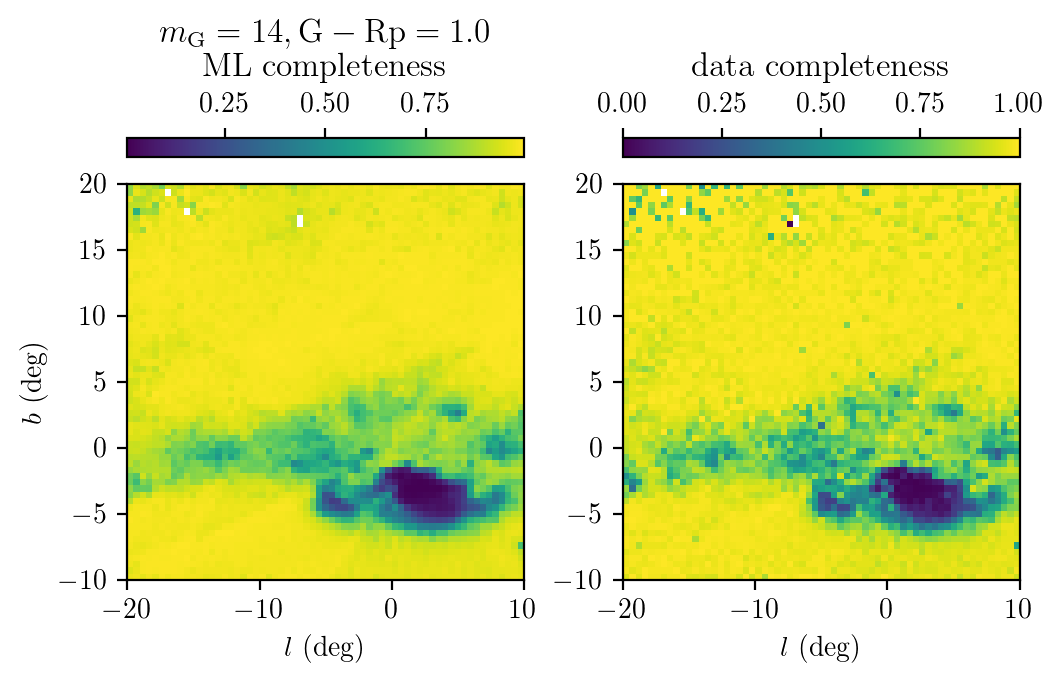

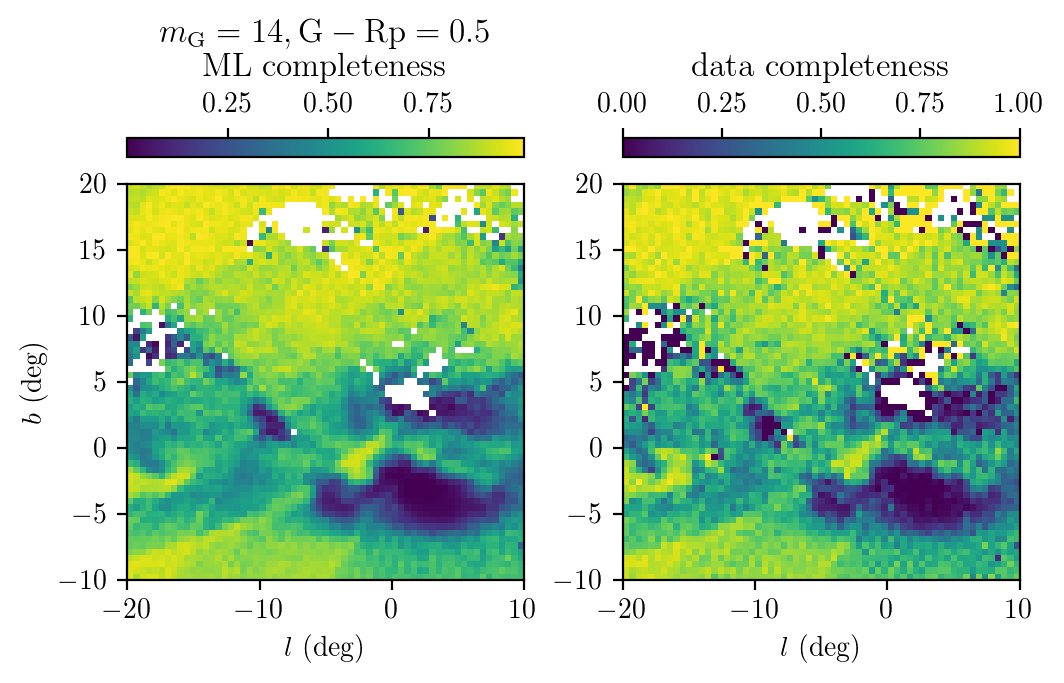

In [19]:
jobs = [
    (model.predict(X, batch_size=8192).reshape(-1), data['S'], 'mean', '$m_\mathrm{G}=14, \mathrm{G-Rp}=1.0$', (data['m_G'] >= 13.6) & (data['m_G'] < 14.4) & (data['G-Rp'] >= 0.8) & (data['G-Rp'] < 1.2), dict()),
    (model.predict(X, batch_size=8192).reshape(-1), data['S'], 'mean', '$m_\mathrm{G}=14, \mathrm{G-Rp}=0.5$', (data['m_G'] >= 13.6) & (data['m_G'] < 14.4) & (data['G-Rp'] >= 0.3) & (data['G-Rp'] < 0.7), dict()),
]

for z_model, z_data, statistic, title, idx, kw in jobs:
    if idx is None:
        idx = np.ones(len(data), dtype=bool)
    fig, axs = plt.subplots(2, 2,
            figsize=(6, 3*1.1),
            dpi=200,
            gridspec_kw=dict(height_ratios=[0.1, 2]),
            layout='compressed')
    caxs, axs = axs

    for ax in axs:
        ax.set_xlabel('$l\mathrm{\ (deg)}$')
        ax.set_aspect('equal')
        ax.invert_xaxis()
    axs[0].set_ylabel('$b\mathrm{\ (deg)}$')

    grid_size = 64
    xmin, xmax = xlim
    ymin, ymax = ylim
    x_bins = np.linspace(xmin, xmax, grid_size)
    y_bins = np.linspace(ymin, ymax, grid_size)

    ret = binned_statistic_2d(data[idx]['l'].value, data[idx]['b'].value, z_model[idx], statistic=statistic, bins=[x_bins, y_bins])
    im = axs[0].imshow(ret.statistic.T,
            origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='viridis',
            aspect='equal', rasterized=True, interpolation='none', **kw)
    cb = fig.colorbar(im, cax=caxs[0], orientation='horizontal')
    cb.ax.xaxis.set_ticks_position('top')
    caxs[0].set_title(title + '\nML completeness')
    
    ret = binned_statistic_2d(data[idx]['l'].value, data[idx]['b'].value, z_data[idx], statistic=statistic, bins=[x_bins, y_bins])
    im = axs[1].imshow(ret.statistic.T,
            origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='viridis',
            aspect='equal', rasterized=True, interpolation='none', **kw)
    cb = fig.colorbar(im, cax=caxs[1], orientation='horizontal')
    cb.ax.xaxis.set_ticks_position('top')
    caxs[1].set_title('\ndata completeness')
    
    
    plt.show()